# New York Stock Exchange

## コンテキスト
このデータセットは、基礎的および技術的分析のための遊び場です。
株式のトラフィックの30％はすでに機械によって生成されていると言われていますが、取引は完全に自動化できますか？そうでない場合でも、履歴データから多くのことを学ぶ必要があります。

## コンテンツ

データセットは、次のファイルで構成されています。

- prices.csv：未加工、現状のままの価格。株式市場の新規期間が短い企業の場合、ほとんどのデータは2010年から2016年末までに及びます。約がありました。その時点で140の株式が分割されていますが、このセットはそれを考慮していません。 

- price-split-adjusted.csv：価格と同じですが、分割の調整が追加されています。 

- Securities.csv：セクターの区分を持つ各企業の一般的な説明

- ファンダメンタルズ.csv：SEC 10K年次フィリング（2012-2016）から抽出されたメトリックは、一般的なファンダメンタル指標のほとんどを導き出すのに十分なはずです。

## 謝辞
価格はYahoo Financeから取得され、基本はNasdaq Financialsから取得され、EDGAR SECデータベースからいくつかのフィールドが拡張されています。

## インスピレーション
このデータで試してみることができるものがいくつかあります。1日先の予測：Rolling Linear Regression、ARIMA、Neural Networks、LSTM Momentum / Mean-Reversion Strategiesセキュリティクラスタリング、ポートフォリオ構築/ヘッジどの会社が倒産する可能性が最も高いか？過小評価されているのはどれか（その後の価格の振る舞い）、投資収益率とは？

## データ分析
必要になるライブラリ呼ぶ

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
# from sklearn.neural_network import MLPClassifier
# from sklearn.grid_search import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
#from mlxtend.classifier import StackingClassifier

from collections import Counter


## 1. Data loading

In [11]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#  from subprocess import check_output
# print(check_output(["ls", "~/Dropbox/@00_input/Mental_Health/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#reading in CSV's from a file path
train_df = pd.read_csv('~/Dropbox/@00_input/nyse/prices.csv')


#Pandas: whats the data row count?
print("shape", train_df.shape)
    
#Pandas: whats the distribution of the data?
print("+++ describe +++")
print(train_df.describe())
    
#Pandas: What types of data do i have?
print("+++ info +++")
print(train_df.info())

shape (851264, 7)
+++ describe +++
                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%        52.770000      52.799999      52.230000      53.310001   
75%        79.879997      79.889999      79.110001      80.610001   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08  
+++ info +++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-n

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [4]:
train_df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (train_df.apply(num_missing, axis=0) )#axis=0 defines that function is to be applied on each column

Missing values per column:
date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


## 2. Data cleaning

In [5]:
#dealing with missing data
#Let’s get rid of the variables "Timestamp",“comments”, “state” just to make our lives easier.
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


Cleaning NaN

In [6]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [7]:
train_df['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [8]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [9]:
print(train_df['Age'].unique())

[         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61          11          72]


In [10]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [11]:
print(train_df['self_employed'].unique())

['NaN' 'Yes' 'No']


In [12]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [13]:
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' 'NaN']


In [14]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


## 3. Encoding data

In [15]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


## Testing there aren't any missing data

In [16]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

In [17]:
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


## 4. Covariance Matrix. Variability comparison between categories of variables

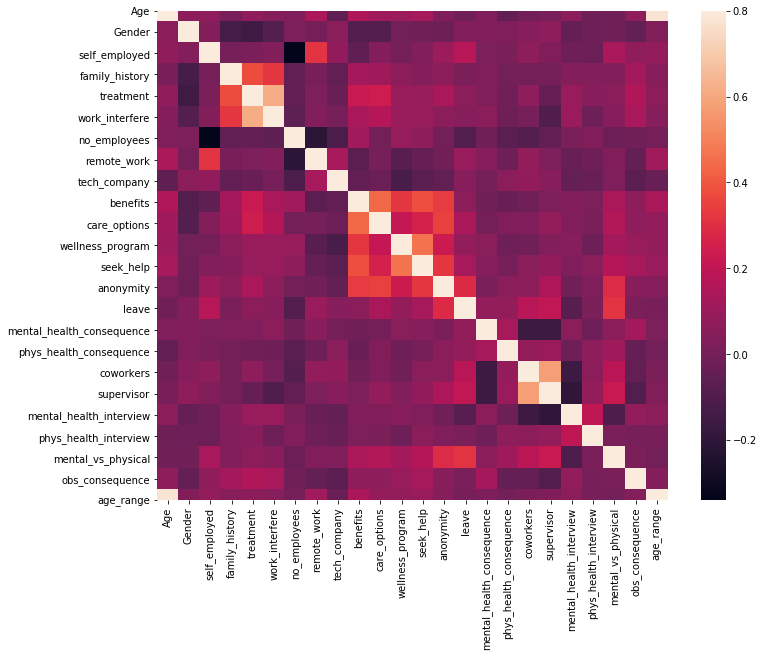

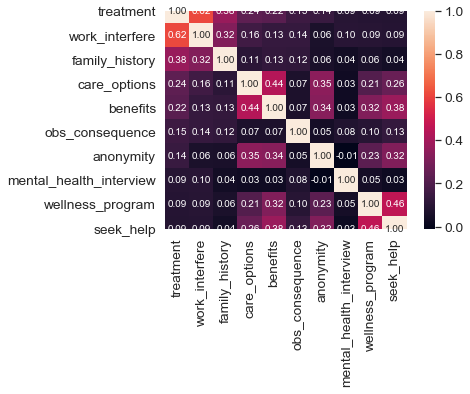

In [18]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 5. Some charts to see data relationship

Distribiution and density by Age

Text(0.5, 0, 'Age')

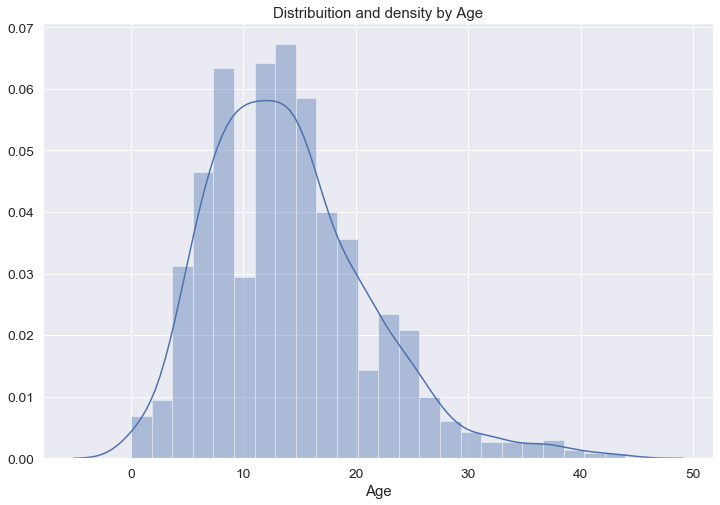

In [19]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

Separate by treatment

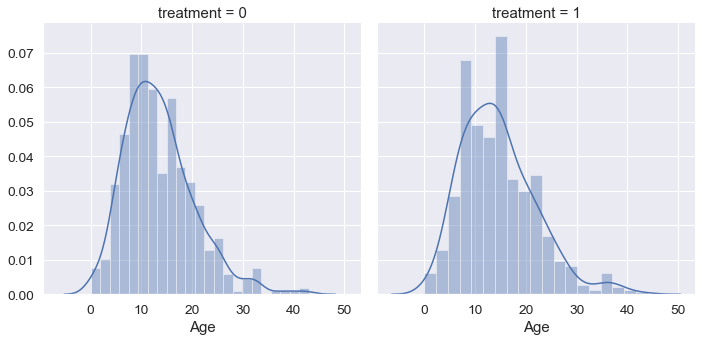

In [21]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', height=5)
g = g.map(sns.distplot, "Age")

How many people has been treated?

Text(0.5, 1.0, 'Total Distribuition by treated or not')

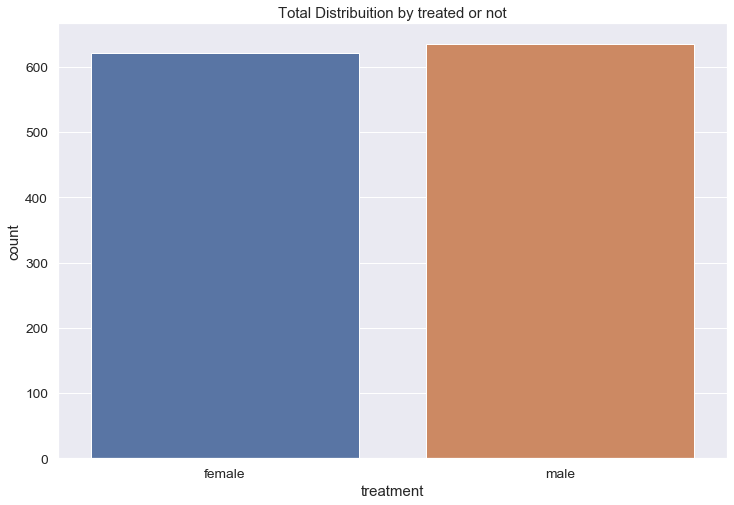

In [22]:
# Let see how many people has been treated
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

Draw a nested barplot to show probabilities for class and sex

/Users/seijisuzuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/seijisuzuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


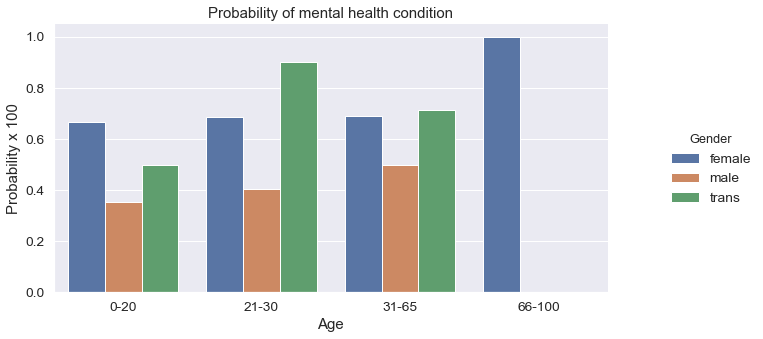

In [23]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for family history

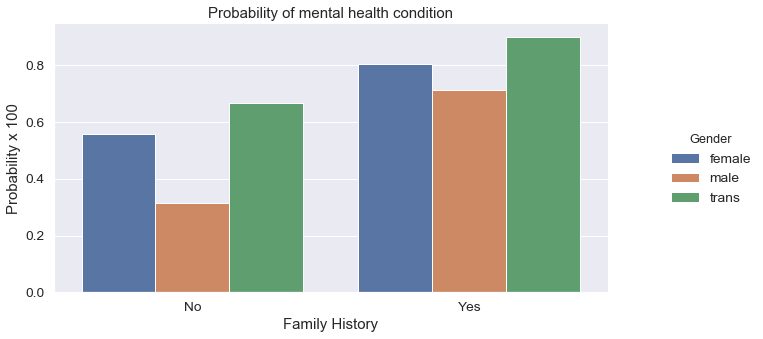

In [24]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for care options

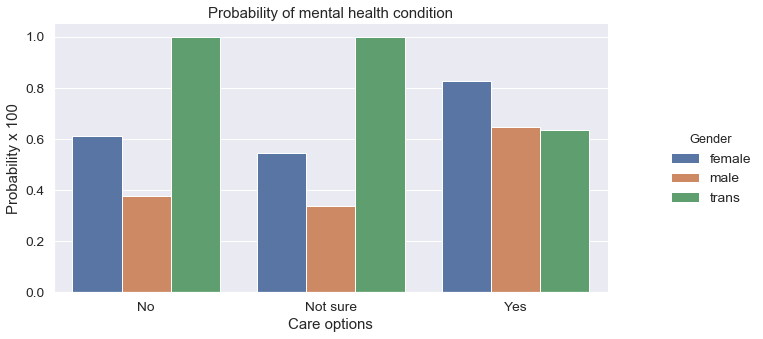

In [25]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for benefits

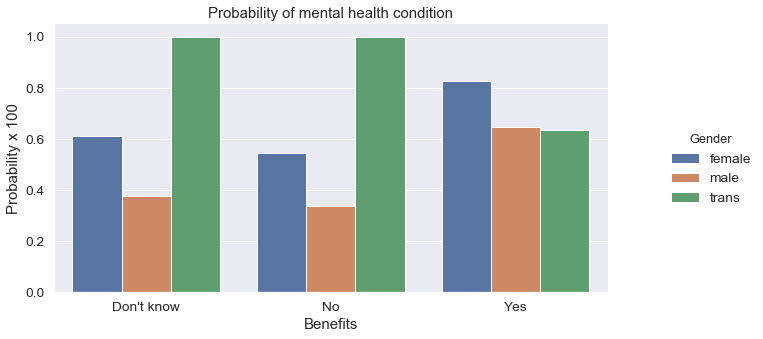

In [27]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for work interfere

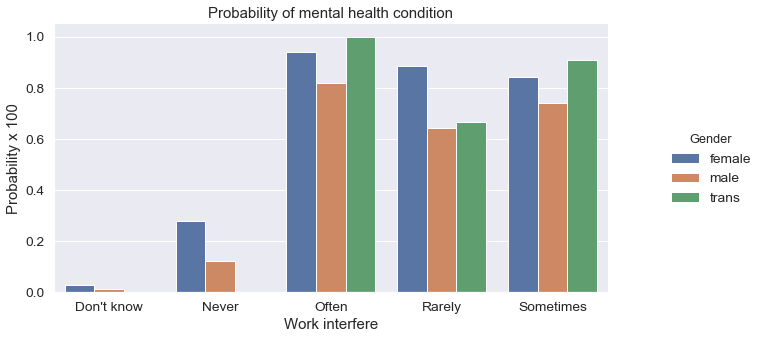

In [28]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

## 6. Scaling and fitting

Features Scaling We're going to scale age, because is extremely different from the othere ones.

In [29]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


Spliltting the dataset

In [30]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

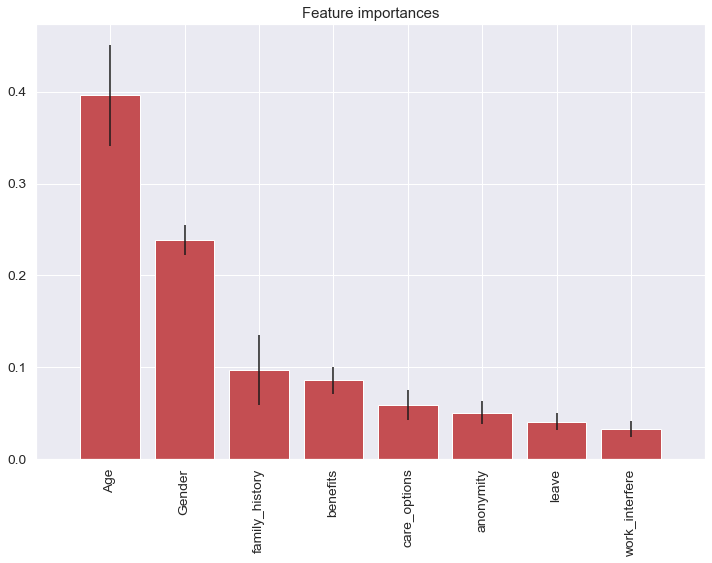

In [31]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()